# Samplomatic: Hello World!

In this tutorial, we take a deep dive into Samplomatic and its core concepts.<br>

After completing this tutorial, you will be able to:
- Utilize boxes and annotations to specify how you intend to randomize the content of a circuit.
- Generate randomized sets of parameters using the `Samplex`.
- Execute randomized circuits on IBM's QPUs through the `Executor` program.
- But above all, understand how to use Samplomatic, `NoiseLearnerV3`, and `Executor` to express a wide array of error mitigation protocols !

Let's begin by looking at twirl-annotated boxes.

## 1. Boxes and the `Twirl` annotation

Twirling is the process of inserting randomly-chosen gates before a noisy operation and undoing them afterward. This randomization does not mutate the intended computation, but it averages the noise into a simpler form. As an example, in Pauli Twirling we sample gates from the group of Pauli gates, in order to average to noise to stochastic Pauli errors.

To see how to twirl the content of a circuit using Samplomatic, consider the following circuit, which prepares the three-qubit Greenberger–Horne–Zeilinger (GHZ) state

$$ 
|\textrm{GHZ}\rangle_3=\frac{|000\rangle+|111\rangle}{\sqrt{2}},
$$

applies Pauli-X rotations, and measures the resulting state.

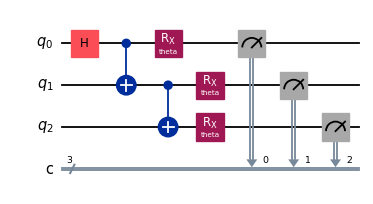

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter

circuit = QuantumCircuit(3, 3)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.rx(Parameter("theta"), [0, 1, 2])
circuit.measure([0, 1, 2], [0, 1, 2])

circuit.draw("mpl", scale=0.65)

We can group instructions into a box by opening a context manager. To indicate that we wish to twirl the content of the box, we pass a `Twirl` annotation as argument to the context manager.

The following snippet shows how to group the instructions of the GHZ circuit above into twirl-annotated boxes.

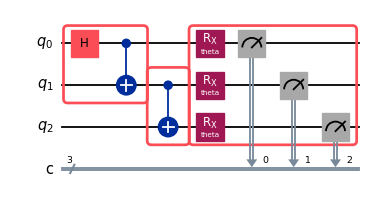

In [2]:
from samplomatic import Twirl

boxed_circuit = QuantumCircuit(3, 3)

# Pauli-twirled box with gates
with boxed_circuit.box(annotations=[Twirl()]):
    boxed_circuit.h(0)
    boxed_circuit.cx(0, 1)
    
# Pauli-twirled box with gates with a different decomposition
with boxed_circuit.box(annotations=[Twirl(decomposition="rzrx")]):
    boxed_circuit.cx(1, 2)
    
# Pauli-twirled box with measurements
with boxed_circuit.box(annotations=[Twirl()]):
    boxed_circuit.rx(Parameter("theta"), [0, 1, 2])
    boxed_circuit.measure([0, 1, 2], [0, 1, 2])

boxed_circuit.draw("mpl", scale=0.65)

Each instruction in `boxed_circuit` owns a box, and each box is correctly annotated.

In [3]:
from qiskit.circuit import BoxOp

for idx, instruction in enumerate(boxed_circuit):
    # Each instruction owns a box
    assert isinstance(instruction.operation, BoxOp)

    # Each instruction owns a `Twirl` annotation
    print(f"Annotations of box #{idx}: {instruction.operation.annotations}\n")

Annotations of box #0: [Twirl(group='pauli', dressing='left', decomposition='rzsx')]

Annotations of box #1: [Twirl(group='pauli', dressing='left', decomposition='rzrx')]

Annotations of box #2: [Twirl(group='pauli', dressing='left', decomposition='rzsx')]



Annotations can be viewed as directives, statements of intent. Samplomatic, as a collection of tools to interpret those directives. Before we learn about the first of these tools (the `build` method), let's examine the directives conveyed by the `Twirl` annotation.

### The `Twirl` annotation and its attributes

Adding Pauli-twirling gates before and after every noisy operation can significantly increase the depth of our circuits. To minimize the increase in depth, Samplomatic adds a single one-qubit unitary (or *dressing*) per qubit per box. These dressings are sufficient to implement the Pauli-twirling gates, as well as every one-qubit gate that was present in the boxes.

We can now understand two of the attributes of the `Twirl` annotation:
- A `Twirl` annotation with `Twirl.dressing` set to `"left"` (respectively `"right"`) is a directive to add dressing gates on the l.h.s. (respectively r.h.s.) of the two-qubit gates or measurements in the box.
- The value of `Twirl.decomposition` specifies how the dressing gates must be syntethized. All the supported decompositions are universal for one-qubit computation, which guarantees that the dressing can implement every one-qubit unitary (or every sequence of one-qubit unitaries) that is present in the box.

In our example, the `Twirl` annotations provide directives to add dressings on the left-hand side of the content of the boxes. The dressing of the first and last boxes will be synthesized as an RZ-SX-RZ-SX-RZ chain (with parametric RZ), while the dressing of the second box will be synthesized as an RZ-RX-RZ chain (with parametric RZs and RX). 

### The `build` method

When a circuit contains twirl-annotated boxes, we can use the `build` method of Samplomatic to interpret the circuit into a pair of objects: a template circuit and a samplex.

In [4]:
from samplomatic import build

template_circuit, samplex = build(boxed_circuit)

Let us take a look at these two objects.

### The template circuit
The `template_circuit` circuit is structurally equivalent to `boxed_circuit`, meaning that it contains the same two-qubit gates and measurements as `boxed_circuit`. However, its one-qubit gates are different: the original gates are replaced by the dressing gates, synthesized as prescribed by the `Twirl` annotations. These dressing gates are sufficient to implement:
- The one-qubit gates in `boxed_circuit`--in our case, the Hadamard gate and the Pauli-X rotations.
- The Pauli-twirling gates.

In our example, given that the value of `Twirling.dressing` is `"left"` for every box, the parametric one-qubit gates are placed on the left-hand side of the corresponding two-qubit gates or measurements. The dressing gates of the first and last box appear as an RZ-SX-RZ-SX-RZ chain, in agreement with the value of `Twirling.decomposition`, while the dressing gates of the central box appear as an RZ-RX-RZ chain.

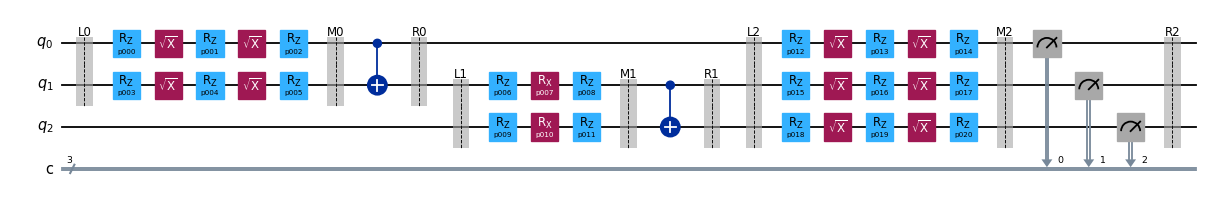

In [5]:
template_circuit.draw("mpl", scale=0.65, fold=100)

#### The Samplex

The `samplex` encodes all the information that is required to generate randomized parameters for `template_circuit`. Conceptually, it represents a probability distribution for the parameters in `template_circuit` and for the classical information required to post-process its outputs.

The following cell shows how to generate `5` sets of parameters for `template_circuit`. As can be seen, the outputs of `samplex.sample` contain:
- The `parameter_values` to implement the Hadamard gate, the RX gates, and the twirling gates. These come in the form of an array of floats of shape `(5, 21)`, where `5` is the number of randomizations and `21` is the number of parameters in the template circuit (hence, `5` sets of `21` randomized parameters).
- The `measurement_flips.meas`, namely the bit-flips to undo the effect of twirling the measurements and recover the correct results. These come in the form of an array of boolean of shape `(5, 1, 3)`, where `5` is the number of randomizations and `3` is the number of measurements.

In [6]:
# print the samplex to learn its inputs and outputs
print(samplex)

Samplex(<19 nodes>)
  Inputs:
  - 'parameter_values' <float64[1]>: Input parameter values to use during sampling.

  Outputs:
    * 'measurement_flips.c' <bool['num_randomizations', 1, 3]>: Bit-flip corrections for
        measurement twirling.
    * 'parameter_values' <float32['num_randomizations', 21]>: Parameter values valid for an
        associated template circuit.



In [7]:
# specify the value of 'theta'
samplex_input = samplex.inputs().bind(parameter_values=[0.1])

# use the `samplex.sample` method to sample 5 sets of parameters
outputs = samplex.sample(samplex_input, num_randomizations=5)

# access the sampled values as you'd access values in a dictionary
parameter_values = outputs["parameter_values"]
measurement_flips = outputs["measurement_flips.c"]

In [8]:
# use `describe` for a human-readable description of the outputs
print(f"\nSamplex outputs:")
print(outputs.describe())

print(f"Shape of 'parameter_values': {parameter_values.shape}.")
print(f"Shape of 'measurement_flips.meas': {measurement_flips.shape}.\n")


Samplex outputs:
* 'measurement_flips.c' <bool['num_randomizations', 1, 3]>: Bit-flip corrections for measurement twirling.
* 'parameter_values' <float32['num_randomizations', 21]>: Parameter values valid for an associated template circuit.

Shape of 'parameter_values': (5, 21).
Shape of 'measurement_flips.meas': (5, 1, 3).



Let us double-check that the parameters generated above are correct. To do so:
- We assign the parameter values generated above to `template_circuit`.
- Using Qiskit's `Operator` class, we verify that the resulting circuit is equivalent to the circuit that we started from--the three-qubit GHZ circuit.

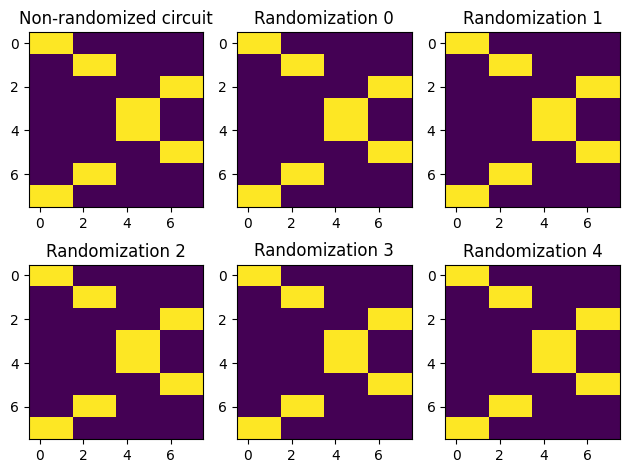

In [9]:
from qiskit.quantum_info import Operator, Pauli
import matplotlib.pyplot as plt
import numpy as np

# We want to plot unitary matrix amplitudes, so we need to remove the non-unitary measurements
circuit.remove_final_measurements()
unitary = Operator(circuit.assign_parameters([0.1]))

# Plot magnitudes of the unitary matrix representation of the circuit
plt.subplot(2, 3, 1)
plt.imshow(np.abs(unitary))
plt.title("Non-randomized circuit")

# For each randomization we sampled, plot the unitary matrix representation
for idx in range(5):
    bound_template = template_circuit.assign_parameters(outputs["parameter_values"][idx])
    bound_template.remove_final_measurements()

    # Our example does measurement twirling by compiling random bitflip gates before the
    # measurements, so we need to undo these at the operator level for each randomization.
    # We do this by casting them to Paulis and composing with the bound circuit's unitary
    meas_flips = Pauli(([0] * boxed_circuit.num_qubits, outputs["measurement_flips.c"][idx, 0]))
    bound_unitary = Operator(bound_template) & meas_flips

    # Plot magnitudes of the unitary matrix represenation of the circuit
    plt.subplot(2, 3, idx + 2)
    plt.imshow(np.abs(bound_unitary))
    plt.title(f"Randomization {idx}")

plt.tight_layout()

### The Samplex as a DAG

The `samplex` object is implemented as a Directed Acyclic Graph (DAG). Each node in the graph represents a different procedure to either:
- **Sample** elements from a set, such as the set of all Paulis in the case of Pauli twirling.
- **Process** the sampled elements, for example:
  -  To commute them with a gate.
  -  To combine many into one.
  -  Or to change their representation, e.g., to convert a Pauli operator into the equivalent U2 gate representation.
- **Convert** the resulting objects into parameters for `template_circuit`.

The edges represent dependencies between nodes. In particular, an edge from node A to node B indices that the task of B depends on A and cannot be executed before the task of A is executed.

> **_NOTE:_**  Given its internal implementation as a graph, multiple sampling, processing, and convertion steps can be carried out in parallel, making the Samplex highly efficient at generating random sets of parameters. 

The two cells below the `samplex` for our GHZ circuit, alongside `template_circuit` for clarity. Let us explain the role of each node following execution order, in the simple case where a single set of parameters is produced.

The three red stars (one per box) are the nodes in charge of generating of random Pauli gates. Each of these nodes generates two instances of a randomly-chosen Pauli operator, with support on as many qubit as are in the box. Intuitively, one can think of them as a pair of "virtual" (i.e., non-physical) gates generated on top of the barriers marked as ``M``, as illustrated by the stars in the `template_circuit` figure.

After the virtual Pauli pairs are generated, they travel through the circuit in opposite directions, one towards the beginning of the circuit and one towards the end. The green circles in the `samplex` keep track of their evolution as they commute through gates, or are combined with other virtual Paulis that they meet along the way.

When the virtual Paulis meet parametric-one qubit gates or measurements, their journey ends. The bow-tie nodes convert them into parameter values for the template circuit (the blue bow ties) or into an array of measurement flips (the purple bow tie).

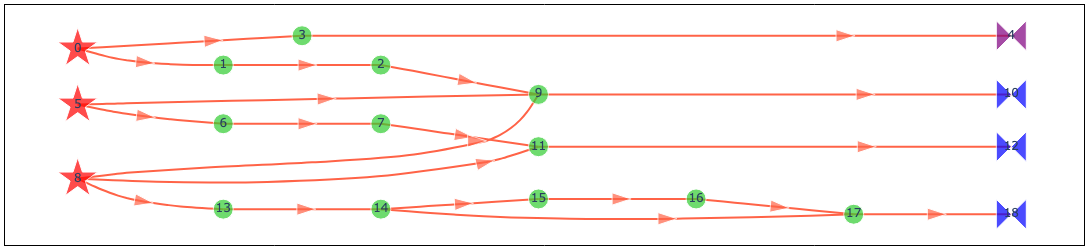

In [10]:
fig = samplex.draw()
fig.update_layout(width=900, height=250)
fig.show()

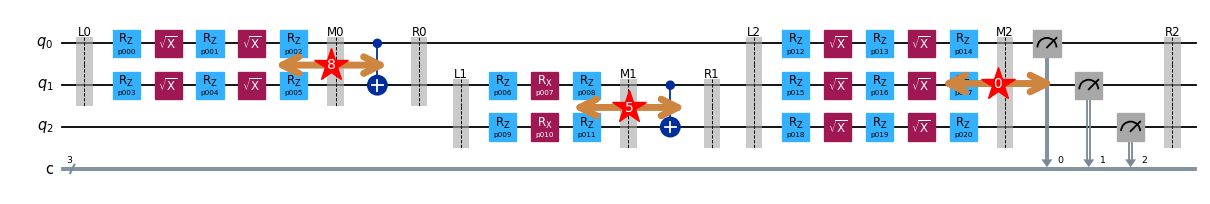

In [11]:
from IPython.display import display
from qiskit.visualization import circuit_drawer
from matplotlib.patches import FancyArrowPatch

fig = circuit_drawer(template_circuit, output="mpl", scale=0.65, fold=100)
ax = fig.gca()

pos = [(0.27, 0.7), (0.52, 0.47), (0.83, 0.6)]

# uncomment to show twirling
for (x, y), text in zip(pos, ["8", "5", "0"]):
    ax.plot(x, y, marker="*", color="red", markersize=25, zorder=100, transform=ax.transAxes)
    ax.text(x, y, text, color="white", ha="center", va="center", fontsize=10, zorder=101, transform=ax.transAxes)


for idx, (x, y) in enumerate(pos):
    arrow = FancyArrowPatch(
        (x-0.05, y), 
        (x+0.05, y), 
        arrowstyle="<->", 
        transform=ax.transAxes, 
        zorder=99, 
        mutation_scale=30,
        linewidth=5,
        color="peru",
    )
    ax.add_patch(arrow)

display(fig)

When a circuit contains a larger number of qubits and instructions, the number of nodes in the samplex graph grows accordingly. Yet, given its implementation as a graph, the samplex remains highly performant. 

To get a sense of the samplex grows, consider the following utility-type circuit, which is easy to scale both in number of qubits and in depth.

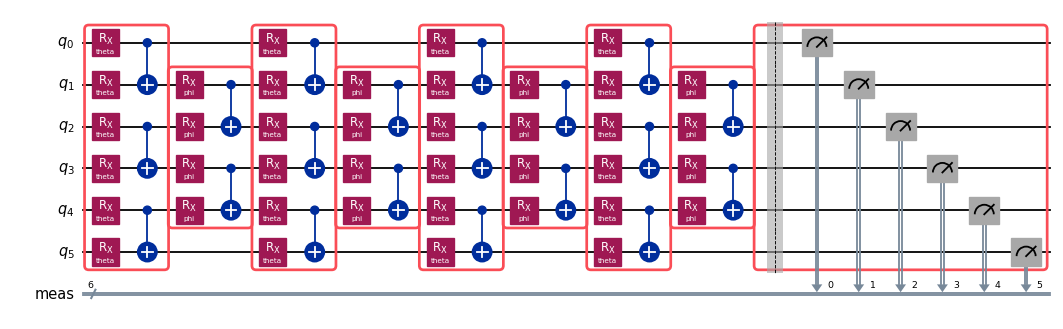

In [12]:
# Increase `num_qubits` and `num_layers` to see how the samplex changes
num_qubits = 6
num_layers = 4

if num_qubits % 2 != 0:
    raise ValueError(f"Please provide an even value for 'num_qubits'.")

boxed_circuit = QuantumCircuit(num_qubits)

theta = Parameter("theta")
phi = Parameter("phi")

for _ in range(num_layers):
    with boxed_circuit.box([Twirl()]):
        boxed_circuit.rx(theta, range(num_qubits))
        boxed_circuit.cx(range(0, num_qubits - 1, 2), range(1, num_qubits, 2))
        
    with boxed_circuit.box([Twirl()]):
        boxed_circuit.rx(phi, range(1, num_qubits-1))
        boxed_circuit.cx(range(1, num_qubits - 1, 2), range(2, num_qubits, 2))
    
with boxed_circuit.box([Twirl()]):
    boxed_circuit.measure_all()

boxed_circuit.draw("mpl", scale=0.65, fold=100)

The number of nodes in the `samplex` has grown considerably!

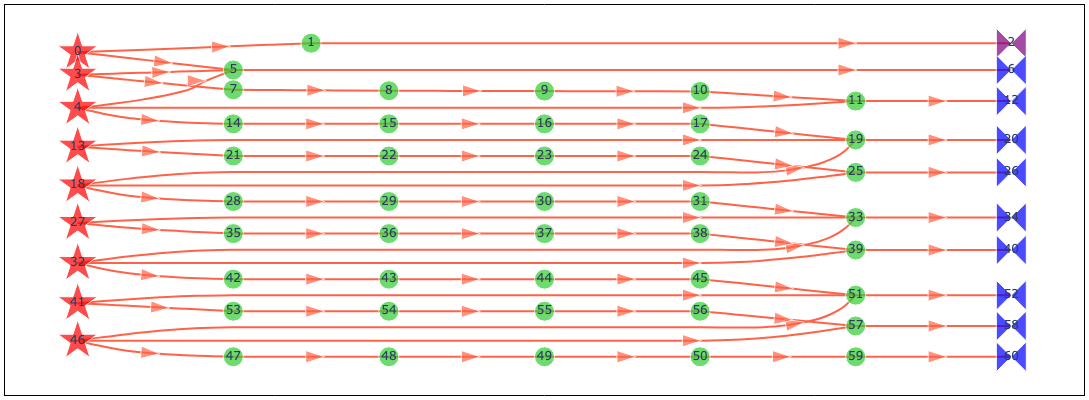

In [13]:
template_circuit, samplex = build(boxed_circuit)

fig = samplex.draw()
fig.update_layout(width=900, height=400)
fig.show()

### When inconsistent dressings cause problems.

When grouping your operations into boxes for the first time, setting `Twirling.dressing` can be challenging. As an example, try running the cell below, where we have tried right-dressing the one of the boxes of our three-qubit GHZ circuit. The `build` method raises an error. Can you tell what is going wrong?

<details>
<summary>Double-click here for the solution.</summary>
    Dressing gates are added to the right-hand side of the central box. Thus, the virtual Pauli on qubit `q2` emitted towards the beginning of the circuit does not find any dressing gate able to implement it.
</details>

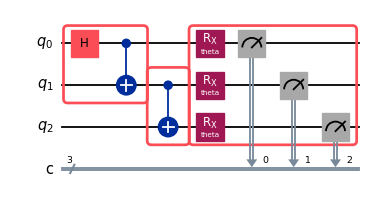

In [14]:
boxed_circuit = QuantumCircuit(3, 3)

with boxed_circuit.box(annotations=[Twirl()]):
    boxed_circuit.h(0)
    boxed_circuit.cx(0, 1)
    
with boxed_circuit.box(annotations=[Twirl(dressing="right")]):
    boxed_circuit.cx(1, 2)
    
with boxed_circuit.box(annotations=[Twirl()]):
    boxed_circuit.rx(Parameter("theta"), [0, 1, 2])
    boxed_circuit.measure([0, 1, 2], [0, 1, 2])

boxed_circuit.draw("mpl", scale=0.65)

# uncomment the line below to see the error
# build(boxed_circuit)

💡 When annotating circuits manually becomes confusing, a few tricks can be useful:
- Consider left-dressing every one of your boxes.
- Place any one-qubit gate on the nearest subsequent box (as it will minimize the depth of the resulting `template_circuit`), but not on a previous box.
- If you do not plan on twirling the measurements, or if your circuit ends with unmeasured qubits, end your circuit with a right-dressed box. It will collect every virtual gate that has not found a collector.

Alternatively, Samplomatic offers an array of built-in pass managers to automate this step.

### Pass managers to automatically group operations into twirl-annotated boxes

The following snippet creates a pass manager that groups gates into boxes, but leaves the measurements outside.

In [15]:
from samplomatic.transpiler import generate_boxing_pass_manager

boxing_pass_manager = generate_boxing_pass_manager(
    enable_gates=True,
    enable_measures=False,
)

Running this pass manager with the three-qubit GHZ circuit generates the following circuit.

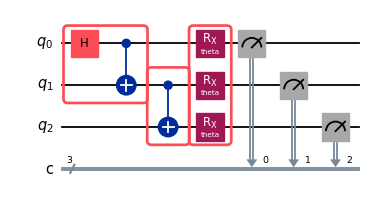

In [16]:
circuit = QuantumCircuit(3, 3)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.rx(Parameter("theta"), [0, 1, 2])
circuit.measure([0, 1, 2], [0, 1, 2])

boxed_circuit = boxing_pass_manager.run(circuit)

boxed_circuit.draw("mpl", scale=0.65)

In [17]:
for idx, instruction in enumerate(boxed_circuit):
    if isinstance(instruction.operation, BoxOp):
        print(f"Annotations of box #{idx}: {instruction.operation.annotations}\n")

Annotations of box #0: [Twirl(group='pauli', dressing='left', decomposition='rzsx')]

Annotations of box #1: [Twirl(group='pauli', dressing='left', decomposition='rzsx')]

Annotations of box #2: [Twirl(group='pauli', dressing='right', decomposition='rzsx')]



The boxing pass managers can be used in conjunction with other pass managers, for example with one of Qiskit's preset pass managers.

In [18]:
from qiskit.transpiler import generate_preset_pass_manager

preset_pass_manager = generate_preset_pass_manager(
    basis_gates=["rz", "sx", "cx"],
    coupling_map=[[0, 1], [0, 2]],  # No CX gate between qubits 1 and 2
    optimization_level=0,
)

# Run the boxing pass manager after the scheduling stage
preset_pass_manager.post_scheduling = boxing_pass_manager

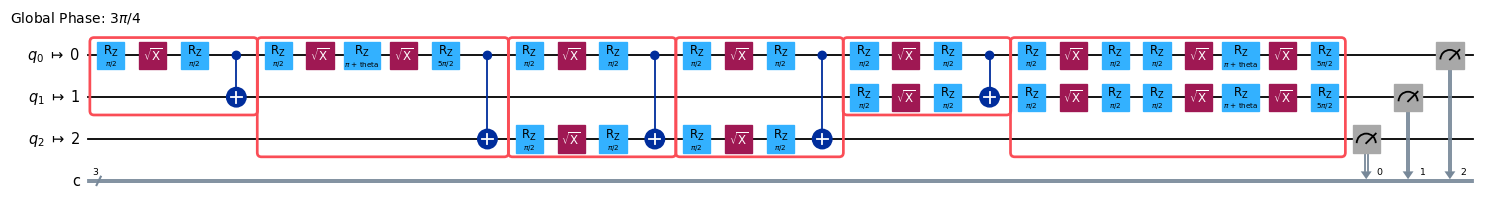

In [19]:
circuit = QuantumCircuit(3, 3)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.rx(Parameter("theta"), [0, 1, 2])
circuit.measure([0, 1, 2], [0, 1, 2])

boxed_circuit = preset_pass_manager.run(circuit)

boxed_circuit.draw("mpl", scale=0.65, fold=100)

## 2. The `InjectNoise` annotation

`InjectNoise` is a directive to use the dressers to inject noise into our circuits. It is designed to be flexible and support a wide range of applications for error mitigation.

Every `InjectNoise` comes with:
- An `InjectNoise.ref` attribute. This is a unique identifier attached to each of these annotations, and it is required by the samplex to correctly assign a noise model to each box.
- An optional `InjectNoise.modifier_ref`, which allows scaling the noise model assigned to a box by multiplicative factors.

The following snippet shows how to add an `InjectNoise` annotation the gate boxes in our three-qubit GHZ circuit.

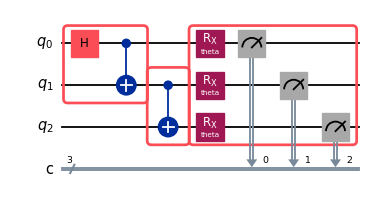

In [20]:
from samplomatic import InjectNoise

boxed_circuit = QuantumCircuit(3, 3)

with boxed_circuit.box(annotations=[Twirl(), InjectNoise(ref="r0", modifier_ref="m0")]):
    boxed_circuit.h(0)
    boxed_circuit.cx(0, 1)
    
with boxed_circuit.box(annotations=[Twirl(), InjectNoise(ref="r1", modifier_ref="m1")]):
    boxed_circuit.cx(1, 2)
    
with boxed_circuit.box(annotations=[Twirl()]):
    boxed_circuit.rx(Parameter("theta"), [0, 1, 2])
    boxed_circuit.measure([0, 1, 2], [0, 1, 2])

boxed_circuit.draw("mpl", scale=0.65)

In [21]:
for idx, instruction in enumerate(boxed_circuit):
    # Each instruction owns a box
    assert isinstance(instruction.operation, BoxOp)

    # Each instruction owns `Twirl` and `InjectNoise` annotations
    print(f"Annotations of box #{idx}:\n {instruction.operation.annotations}\n")

Annotations of box #0:
 [Twirl(group='pauli', dressing='left', decomposition='rzsx'), InjectNoise(ref='r0', modifier_ref='m0')]

Annotations of box #1:
 [Twirl(group='pauli', dressing='left', decomposition='rzsx'), InjectNoise(ref='r1', modifier_ref='m1')]

Annotations of box #2:
 [Twirl(group='pauli', dressing='left', decomposition='rzsx')]



Alternatively, we could have automated the generation of boxes by using a pass manager produced as follows.

In [22]:
# A pass manager that twirls gate and measurement boxes alike, but that injects
# noise only on gate boxes.
boxing_pass_manager = generate_boxing_pass_manager(
    enable_gates=True,
    enable_measures=True,
    inject_noise_targets="gates",
    inject_noise_strategy="individual_modification",
)

Using the `build` method, we construct the template circuit and the samplex.

In [23]:
template_circuit, samplex = build(boxed_circuit)

In [24]:
# print the samplex to learn its inputs and outputs
print(samplex)

Samplex(<23 nodes>)
  Inputs:
  - 'parameter_values' <float64[1]>: Input parameter values to use during sampling.
  - 'pauli_lindblad_maps.r0' <PauliLindbladMap>: A PauliLindblad map acting on 2 qubits, with
      'num_terms_r0' terms.
  - 'pauli_lindblad_maps.r1' <PauliLindbladMap>: A PauliLindblad map acting on 2 qubits, with
      'num_terms_r1' terms.

  - 'local_scales.m0' <float64['num_terms_r0']>: (Optional) An array of factors by which to
      scale individual rates of a Pauli Lindblad map, where the order should match the
      corresponding list of terms.
  - 'local_scales.m1' <float64['num_terms_r1']>: (Optional) An array of factors by which to
      scale individual rates of a Pauli Lindblad map, where the order should match the
      corresponding list of terms.
  - 'noise_scales.m0' <float64[]>: (Optional) A scalar factor by which to scale rates of a
      Pauli Lindblad map.
  - 'noise_scales.m1' <float64[]>: (Optional) A scalar factor by which to scale rates of a
     

<details>
    <summary>What's the difference between noise scales and local scales?</summary>
    As can be seen above, both of them are optional inputs. However, the required type is different. In particular, a noise scale is a float that allows scaling noise models uniformly, meaning that each term in the noise model is scaled by the same multiplicative factor. On the contrary, local scales are arrays of floats that allow scaling the terms in the noise model by individual factors.
</details>

<details>
    <summary>And what about the Pauli signs?</summary>
    The Pauli signs are provided as an array of booleans. In our example, this array has two axes, one (the l.h.s.) over randomizations and the other (the r.h.s.) over noise injection sites. The element in position _(i, j)_ is True if in the i-th randomization, noise was injected in the j-th site, otherwise it is False.
</details>

In [25]:
from qiskit.quantum_info import PauliLindbladMap

# specify the values required by the samplex
samplex_input = samplex.inputs().bind(
    **{
        "parameter_values": [0.1],
        "pauli_lindblad_maps.r0": PauliLindbladMap.from_list([("IX", 0.04), ("XX", 0.05)]),
        "pauli_lindblad_maps.r1": PauliLindbladMap.from_list([("XI", 0.02), ("IZ", 0.035)]),
        "noise_scales.m0": 1.2,
    }
)

outputs = samplex.sample(samplex_input, num_randomizations=5)

# use `describe` for a human-readable description of the outputs
print(f"\nSamplex outputs:")
print(outputs.describe())


Samplex outputs:
* 'measurement_flips.c' <bool['num_randomizations', 1, 3]>: Bit-flip corrections for measurement twirling.
* 'parameter_values' <float32['num_randomizations', 21]>: Parameter values valid for an associated template circuit.
* 'pauli_signs' <bool['num_randomizations', 2]>: Signs from sampled Pauli Lindblad maps. The order matches the iteration order of injected noise in the circuit.



The `template_circuit` is equal to the circuit that we get in the absence of noise injection.

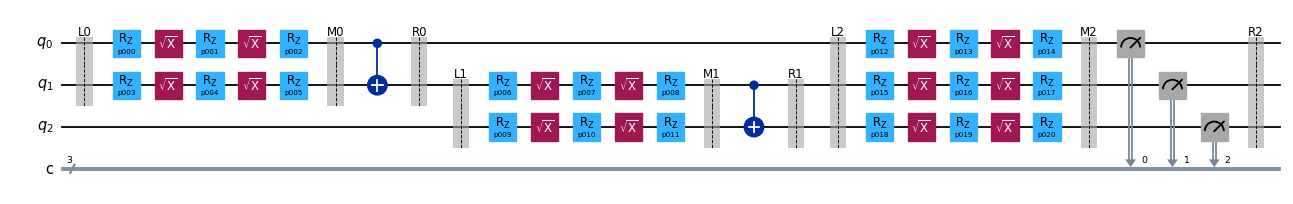

In [26]:
template_circuit.draw("mpl", scale=0.65, fold=100)

However, the `samplex` is different. In particular, we notice that the number of sampling nodes (the red star) has increased. The two new nodes are responsible for sampling Pauli terms for the noise injection.

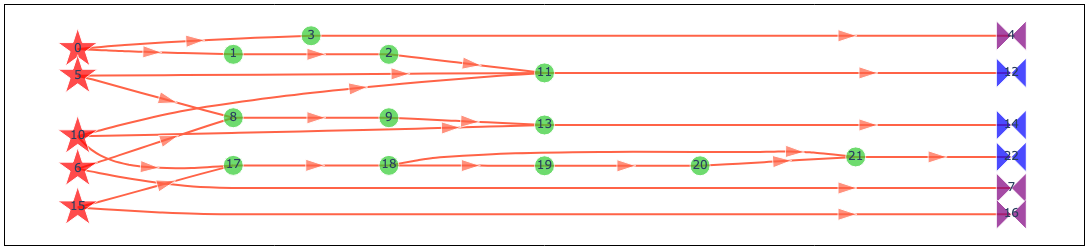

In [27]:
fig = samplex.draw()
fig.update_layout(width=900, height=250)
fig.show()

### Extras on the `InjectNoise` annotation.

<details>
    <summary>Curious to know about the Pauli signs?</summary>
    The Pauli signs come in the form of a boolean array. In our example, the array has two axes, one (the l.h.s. one) over randomization and the other one (the r.h.s one) over noise-injection "sites". The element in position (i, j) is True is in the i-th randomization, noise was injected in site j; otherwise, the element is False. This information can be useful to post-process the outputs, for example when performing PEC mitigation.
</details>

## 3. The `ChangeBasis` annotation

`ChangeBasis` is a directive to add basis changing gates to a box. It supports two different modes:

- `"prepare"`, typically used at the beginning of a circuit to map eigenstates of Pauli-Z to eigenstates of Pauli-X or Pauli-Y.
- `"measure"`, typically used to change basis prior to measurements.

The following snippet shows how to add a `ChangeBasis` to the measurement box of our three-qubit GHZ state:

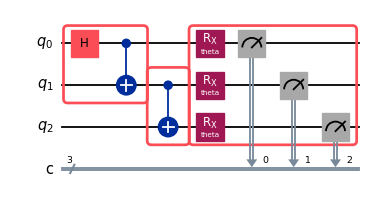

In [28]:
from samplomatic import ChangeBasis

boxed_circuit = QuantumCircuit(3, 3)

with boxed_circuit.box(annotations=[Twirl()]):
    boxed_circuit.h(0)
    boxed_circuit.cx(0, 1)
    
with boxed_circuit.box(annotations=[Twirl()]):
    boxed_circuit.cx(1, 2)
    
# Add basis-changing gates
with boxed_circuit.box(annotations=[Twirl(), ChangeBasis(mode="measure", ref="conclude")]):
    boxed_circuit.rx(Parameter("theta"), [0, 1, 2])
    boxed_circuit.measure([0, 1, 2], [0, 1, 2])

boxed_circuit.draw("mpl", scale=0.65)

In [29]:
for idx, instruction in enumerate(boxed_circuit):
    # Each instruction owns a box
    assert isinstance(instruction.operation, BoxOp)

    # Each instruction owns a `Twirl` annotation, and the measurement instruction a `ChangeBasis`
    print(f"Annotations of box #{idx}:\n {instruction.operation.annotations}\n")

Annotations of box #0:
 [Twirl(group='pauli', dressing='left', decomposition='rzsx')]

Annotations of box #1:
 [Twirl(group='pauli', dressing='left', decomposition='rzsx')]

Annotations of box #2:
 [Twirl(group='pauli', dressing='left', decomposition='rzsx'), ChangeBasis(decomposition='rzsx', mode='measure', ref='conclude')]



Alternatively, we could have automated the generation of boxes by using a pass manager produced as follows.

In [30]:
boxing_pass_manager = generate_boxing_pass_manager(
    enable_gates=True,
    enable_measures=True,
    measure_annotations="all",  # `Twirl` + `ChangeBasis` 
)

In [31]:
template_circuit, samplex = build(boxed_circuit)

In [32]:
# print the samplex to learn its inputs and outputs
print(samplex)

Samplex(<20 nodes>)
  Inputs:
  - 'basis_changes.conclude' <uint8[3]>: Basis changing gates, in the symplectic ordering
      I=0, Z=1, X=2, and Y=3.
  - 'parameter_values' <float64[1]>: Input parameter values to use during sampling.

  Outputs:
    * 'measurement_flips.c' <bool['num_randomizations', 1, 3]>: Bit-flip corrections for
        measurement twirling.
    * 'parameter_values' <float32['num_randomizations', 21]>: Parameter values valid for an
        associated template circuit.



In [33]:
from qiskit.quantum_info import PauliLindbladMap

# specify the values required by the samplex
samplex_input = samplex.inputs().bind(
    **{
        "parameter_values": [0.1],
        "basis_changes.conclude": [0, 2, 3],
    }
)

outputs = samplex.sample(samplex_input, num_randomizations=5)

# use `describe` for a human-readable description of the outputs
print(f"\nSamplex outputs:")
print(outputs.describe())


Samplex outputs:
* 'measurement_flips.c' <bool['num_randomizations', 1, 3]>: Bit-flip corrections for measurement twirling.
* 'parameter_values' <float32['num_randomizations', 21]>: Parameter values valid for an associated template circuit.



The `template_circuit` is equal to the circuit that we get in the absence of `BasisChange` annotations.

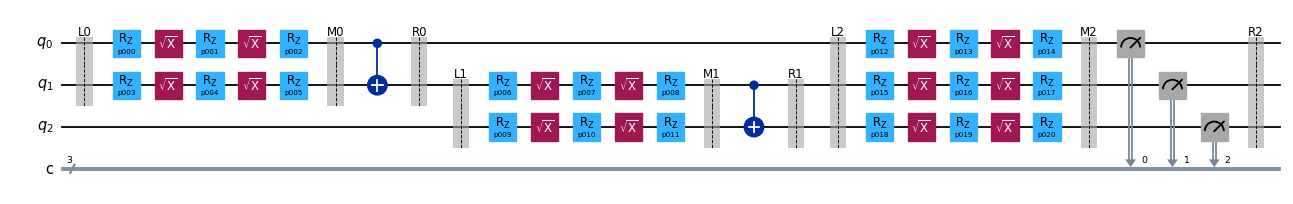

In [34]:
template_circuit.draw("mpl", scale=0.65, fold=100)

But again, `samplex` is different. There is an additional sampling node that is responsible for generating virtual changing-basis gates. These gates travel alongside with the virtual Pauli-twirling gates, and are eventually collected by dressing gates.

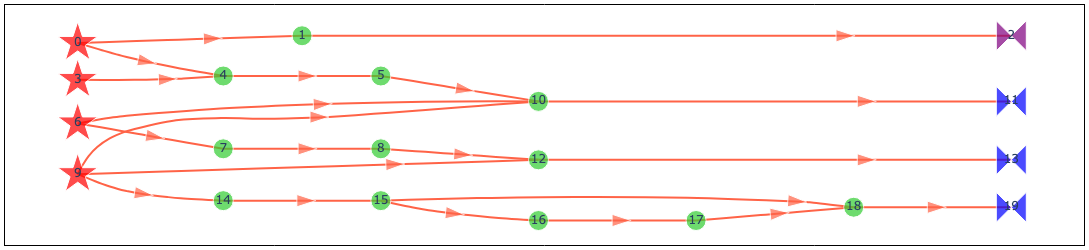

In [35]:
fig = samplex.draw()
fig.update_layout(width=900, height=250)
fig.show()

Again, we can verify the correctness of the parameters generated by `samplex.sample` by assigning these parameters to the template circuit, and comparing the resulting circuit with the expected one.

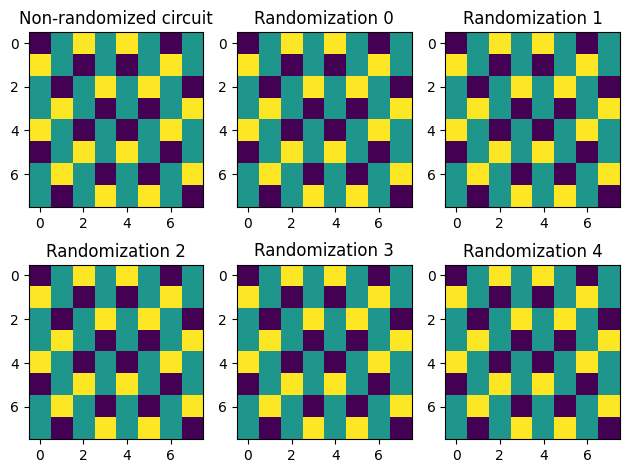

In [36]:
from qiskit.quantum_info import Operator, Pauli
import matplotlib.pyplot as plt
import numpy as np

# initialize the GHZ circuit
circuit = QuantumCircuit(3, 3)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.rx(Parameter("theta"), [0, 1, 2])

# Add basis changing gates
circuit.h(1)
circuit.sx(2)
unitary = Operator(circuit.assign_parameters([0.1]))

# Plot magnitudes of the unitary matrix representation of the circuit
plt.subplot(2, 3, 1)
plt.imshow(np.abs(unitary))
plt.title("Non-randomized circuit")

# For each randomization we sampled, plot the unitary matrix representation
for idx in range(5):
    bound_template = template_circuit.assign_parameters(outputs["parameter_values"][idx])
    bound_template.remove_final_measurements()
    
    meas_flips = Pauli(([0] * boxed_circuit.num_qubits, outputs["measurement_flips.c"][idx, 0]))
    bound_unitary = Operator(bound_template) & meas_flips

    # Plot magnitudes of the unitary matrix represenation of the circuit
    plt.subplot(2, 3, idx + 2)
    plt.imshow(np.abs(bound_unitary))
    plt.title(f"Randomization {idx}")

plt.tight_layout()

## 4. Our new, box-centric programs: `NoiseLearnerV3` and `Executor`

To allow you to take full advantage of Samplomatic, we have recently developed two new programs:
- The `NoiseLearnerV3`, which can be used to learn the noise affecting noisy box instructions.
- The `Executor`, which seamlessly integrates Samplomatic concepts such as `circuit_template` and `samplex` into the pipeline.

In this section, we learn how to use these two programs. To do so, we consider a mirrored-version of the utility circuit with ten qubits. We focus on two tasks:
- Executing the circuit with twirling.
- Executing the circuit with PEC mitigation (cite paper).

Our pipeline will consist of three steps:
1. Preparation, where we generate our target circuit and group its operations into boxes.
2. Learning step, where we learn the noise of the instructions that we wish to mitigate with PEC.
3. Execution step, where we execute our circuit on a backend and analyze the results.

Before moving onto step 1, let us choose a backend to execute our experiments on.

In [37]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
# backend = service.backend("test_heron_pok_1")
backend = service.backend("ibm_kingston")

### 4.1 Preparation

We now initialize a ten-qubit utility-like circuit ...

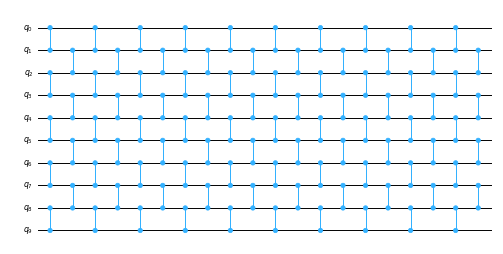

In [38]:
num_qubits = 10
num_layers = 10

qubits = list(range(num_qubits))
circuit = QuantumCircuit(num_qubits)

for layer_idx in range(num_layers):
    # NOTE: Due to a bug in samplomatic, I am unable to include parameters. I will re-run with
    # params when the issue is fixed.
    
    # circuit.rx(Parameter(f"theta_{layer_idx}"), qubits)
    for i in range(num_qubits // 2):
        circuit.cz(qubits[2 * i], qubits[2 * i + 1])

    # circuit.rx(Parameter(f"phi_{layer_idx}"), qubits)
    for i in range(num_qubits // 2 - 1):
        circuit.cz(qubits[2 * i] + 1, qubits[2 * i + 1] + 1)

circuit.draw("mpl", scale=0.35, fold=100)

... and combine it with its inverse to create a mirror circuit.

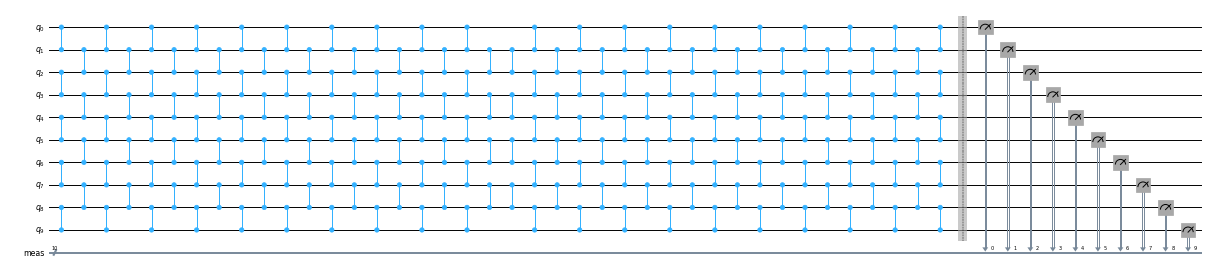

In [39]:
mirror_circuit = circuit.compose(circuit.inverse())
mirror_circuit.measure_all()

mirror_circuit.draw("mpl", scale=0.35, fold=100)

We proceed by utilizing the pass manager to transpile the circuit against our backend, as well as to group gates and measurements into annotated boxes. We begin with creating a circuit with twirled-annotated boxes.

In [40]:
preset_pass_manager = generate_preset_pass_manager(
    backend=backend,
    initial_layout=list(range(40, 50)),
    optimization_level=0,
)

# Run the boxing pass manager after the scheduling stage
preset_pass_manager.post_scheduling = generate_boxing_pass_manager(
    enable_gates=True,
    enable_measures=True,
)

mirror_circuit_twirl = preset_pass_manager.run(mirror_circuit)

Next, we generate a new boxed circuit with `Twirl` and `InjectNoise` annotations.

In [41]:
preset_pass_manager = generate_preset_pass_manager(
    backend=backend,
    initial_layout=list(range(40, 50)),
    optimization_level=0,
)

# Run the boxing pass manager after the scheduling stage
preset_pass_manager.post_scheduling = generate_boxing_pass_manager(
    enable_gates=True,
    enable_measures=True,
    inject_noise_targets="gates",  # no measurement mitigation
    inject_noise_strategy="uniform_modification",
)

mirror_circuit_pec = preset_pass_manager.run(mirror_circuit)

### 4.2 Learning

To minimize the number of noise learning experiments, we begin by identifying the unique instructions in our second circuit (the one with boxes annotated with `InjectNoise`). In defining uniqueness, we say that two box instructions are equal if:
- Their content is equal, up to one-qubit gates.
- Their `Twirl` annotation is equal (every other annotation is disregarded).

This leads to three unique instructions, namely the odd and even gate boxes, and the final measurement box.

In [42]:
from samplomatic.utils import find_unique_box_instructions

unique_box_instructions = find_unique_box_instructions(mirror_circuit_pec.data)
assert len(unique_box_instructions) == 3

We can now initialize a `NoiseLearnerV3`, choose the learning parameters by setting its options, and run a noise learning job.

In [43]:
from qiskit_ibm_runtime.noise_learner_v3 import NoiseLearnerV3

learner = NoiseLearnerV3(backend)

learner.options.shots_per_randomization = 128
learner.options.num_randomizations = 32
learner.options.layer_pair_depths = [0, 1, 2, 4, 16, 32]

# learner_job = learner.run(unique_box_instructions)
learner_job = service.job("d3v5ducv6o9s73cufnu0")

learner_job.job_id()

'd3v5ducv6o9s73cufnu0'

In [44]:
learner_result = learner_job.result()

To convert `result` to the object required by the samplex, we use the `result.to_dict` method.

In [45]:
noise_maps = learner_result.to_dict(instructions=unique_box_instructions, require_refs=False)
noise_maps

{'r0': <PauliLindbladMap with 111 terms on 10 qubits: (0.0004)L(X_3) + (0.00045)L(Y_3) + (0.00205)L(Z_3) + (0.0002)L(X_2) + (0.00003)L(X_3 X_2) + (0.00005)L(Y_3 X_2) + (0.00026)L(Z_3 X_2) + (0.0002)L(Y_2) + (0.00005)L(X_3 Y_2) + (0.00003)L(Y_3 Y_2) + (0.00024)L(Z_3 Y_2) + (0.00087)L(Z_2) + (0.00044)L(X_3 Z_2) + (0.00053)L(Y_3 Z_2) + (0.00027)L(Z_3 Z_2) + (0.00029)L(X_1) + (0.00002)L(X_2 X_1) + (0.00001)L(Y_2 X_1) + (0)L(Z_2 X_1) + (0.00026)L(Y_1) + (0.00004)L(X_2 Y_1) + (0)L(Y_2 Y_1) + (0.00015)L(Z_2 Y_1) + (0.00202)L(Z_1) + (0)L(X_2 Z_1) + (0.00004)L(Y_2 Z_1) + (0)L(Z_2 Z_1) + (0.00025)L(X_6) + (0.00024)L(Y_6) + (0.00024)L(Z_6) + (0.00009)L(X_4) + (0)L(X_4 X_3) + (0.00008)L(X_4 Y_3) + (0.00001)L(X_4 Z_3) + (0.00016)L(Y_4) + (0.00004)L(Y_4 X_3) + (0)L(Y_4 Y_3) + (0)L(Y_4 Z_3) + (0.00033)L(Z_4) + (0)L(Z_4 X_3) + (0)L(Z_4 Y_3) + (0)L(Z_4 Z_3) + (0.00017)L(X_7) + (0.00003)L(X_7 X_6) + (0)L(X_7 Y_6) + (0.00027)L(X_7 Z_6) + (0.00018)L(Y_7) + (0)L(Y_7 X_6) + (0.00003)L(Y_7 Y_6) + (0.0003)L(Y

In [46]:
# TODO: The previous noise learner had nice plotters for results. I plan to make them work with
# the new result objects, so that here we can plot the results.

### 4.3 Execution

The `Executor` runs `QuantumProgram` objects. Each `QuantumProgram` is able to contain several *items*, which you can think of as a pair of template and samplex.

Let us initialize an empty program, requesting `1000` shots for each of its items.

In [47]:
from qiskit_ibm_runtime.quantum_program import QuantumProgram

# Generate a quantum program
program = QuantumProgram(shots=1000)

Next, we append the template and samplex built for `mirror_circuit_twirl`, requesting `900` randomizations. This means that the samplex will produce `900` sets of parameters, and each of them will be executed `1000` times in the QPU.

In [48]:
template_twirl, samplex_twirl = build(mirror_circuit_twirl)

parameter_values=np.random.rand(mirror_circuit.num_parameters)
program.append(template_twirl, samplex=samplex_twirl, samplex_arguments=parameter_values, shape=(900,))

Similarly, we append the template and samplex built for `mirror_circuit_pec`, requesting `900` randomizations.

In [49]:
template_pec, samplex_pec = build(mirror_circuit_pec)

samplex_inputs = samplex_pec.inputs()
samplex_arguments = samplex_inputs.bind(
    # parameter_values=parameter_values,
    **{f"pauli_lindblad_maps.{ref}": lindblad for ref, lindblad in noise_maps.items()},
    **{f"noise_scales.{ref}": -1.0 for ref in noise_maps}  # Set the scales to -1 for PEC
)

program.append(template_pec, samplex=samplex_pec, samplex_arguments=samplex_arguments, shape=(900,))

We can now import the `Executor` and submit a job.

In [50]:
from qiskit_ibm_runtime.executor import Executor

executor = Executor(backend)
# executor_job = executor.run(program)
executor_job = service.job("d3v5vhejbaoc73cprnbg")

executor_job.job_id()

/var/folders/m6/y2_l9svd49s4crlw_70ckvfr0000gn/T/ipykernel_84633/4125104275.py:5: DeprecationWarning:

The RuntimeJob class is deprecated as of qiskit-ibm-runtime 0.38.0 and will be removed no sooner than 3 months after the release date. All primitives now return the RuntimeJobV2 class. The major difference between the two classes is that `Job.status()` is returned as a string in RuntimeJobV2.



'd3v5vhejbaoc73cprnbg'

In [51]:
executor_results = executor_job.result()
executor_results

QuantumProgramResult(<2 results>)

In [52]:
twirl_result = executor_results[0]

print(f"Twirl result keys:\n {list(twirl_result.keys())}\n")
print(f"Shape of results: {twirl_result['meas'].shape}")

Twirl result keys:
 ['meas', 'measurement_flips.meas']

Shape of results: (900, 1000, 10)


In [53]:
pec_result = executor_results[1]

print(f"PEC result keys:\n {list(pec_result.keys())}\n")
print(f"Shape of results: {pec_result['meas'].shape}")

PEC result keys:
 ['meas', 'measurement_flips.meas', 'pauli_signs']

Shape of results: (900, 1000, 10)


The next two cells show how to post-process the results to estimate the expectation values of single-qubit Pauli-Z operators acting on each of the ten active qubits (expected value: `1.0`).

In [54]:
# Undo measurement twirling
twirl_result_unflipped = twirl_result["meas"] ^ twirl_result["measurement_flips.meas"]

# Calculate the expectation values of single-qubit Z operators
exp_vals = 1 - 2 * twirl_result_unflipped.mean(axis=1).mean(axis=0)

for qubit, val in enumerate(exp_vals):
    print(f"Qubit {qubit} -> {np.round(val, 2)}")

Qubit 0 -> 0.84
Qubit 1 -> 0.84
Qubit 2 -> 0.89
Qubit 3 -> 0.81
Qubit 4 -> 0.91
Qubit 5 -> 0.85
Qubit 6 -> 0.9
Qubit 7 -> 0.85
Qubit 8 -> 0.89
Qubit 9 -> 0.87


In [55]:
# Undo measurement twirling
pec_result_unflipped = pec_result["meas"] ^ pec_result["measurement_flips.meas"]

# Calculate the signs for PEC mitigation
signs = np.prod(2 * pec_result["pauli_signs"] - 1, axis=-1)
signs = signs.reshape((signs.shape[0], 1))

# Calculate the expectation values of single-qubit Z operators as required by
# PEC mitigation
exp_vals = 1 - (2 * pec_result_unflipped.mean(axis=1) * signs).mean(axis=0)

for qubit, val in enumerate(exp_vals):
    print(f"Qubit {qubit} -> {np.round(val, 2)}")

Qubit 0 -> 0.98
Qubit 1 -> 0.98
Qubit 2 -> 0.99
Qubit 3 -> 0.98
Qubit 4 -> 1.0
Qubit 5 -> 0.99
Qubit 6 -> 1.01
Qubit 7 -> 0.99
Qubit 8 -> 0.99
Qubit 9 -> 0.98
